## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.** 

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo). 



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder). 

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

100%|██████████| 9912422/9912422 [00:00<00:00, 39536159.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20838756.89it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23963089.46it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2909810.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/20], Train Loss: 155.4687
Epoch [2/20], Train Loss: 120.2801
Epoch [3/20], Train Loss: 114.4067
Epoch [4/20], Train Loss: 111.6376
Epoch [5/20], Train Loss: 109.8963
Epoch [6/20], Train Loss: 108.6736
Epoch [7/20], Train Loss: 107.8344
Epoch [8/20], Train Loss: 107.1133
Epoch [9/20], Train Loss: 106.5343
Epoch [10/20], Train Loss: 106.1248
Epoch [11/20], Train Loss: 105.6587
Epoch [12/20], Train Loss: 105.3463
Epoch [13/20], Train Loss: 105.0463
Epoch [14/20], Train Loss: 104.7858
Epoch [15/20], Train Loss: 104.5462
Epoch [16/20], Train Loss: 104.3622
Epoch [17/20], Train Loss: 104.1537
Epoch [18/20], Train Loss: 103.9803
Epoch [19/20], Train Loss: 103.8301
Epoch [20/20], Train Loss: 103.6717


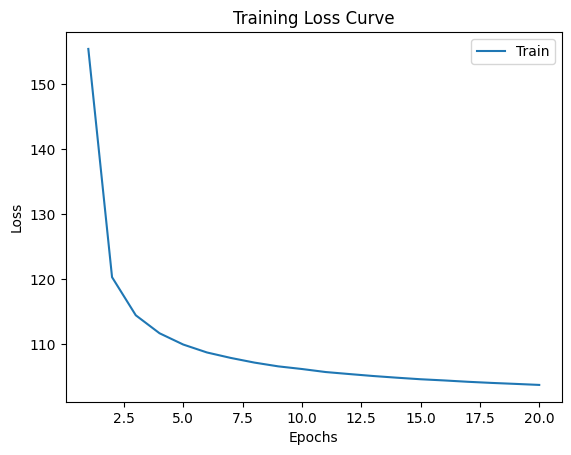

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # Input size 28x28 = 784, output size 256
            nn.ReLU(),
            nn.Linear(256, 128),  # Input size 256, output size 128
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)      # Output mu layer for latent representation
        self.fc_logvar = nn.Linear(128, latent_dim)  # Output logvar layer for latent representation
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Input size latent_dim, output size 128
            nn.ReLU(),
            nn.Linear(128, 256),         # Input size 128, output size 256
            nn.ReLU(),
            nn.Linear(256, 784),         # Input size 256, output size 784 (reconstructed image)
            nn.Sigmoid()                  # Sigmoid activation for image pixel intensities (0-1)
        )
    
    # Encoding function
    def encode(self, x):
        x = x.view(-1, 784)  # Flatten input images into a vector
        x = self.encoder(x)  # Pass through encoder layers
        mu = self.fc_mu(x)   # Get mu
        logvar = self.fc_logvar(x)  # Get logvar
        return mu, logvar
    
    # Reparameterization trick for sampling latent space
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)    # Random noise with the same size as std
        return mu + eps * std           # Reparameterization trick
    
    # Decoding function
    def decode(self, z):
        return self.decoder(z)  # Pass through decoder layers
    
    # Forward pass of the VAE
    def forward(self, x):
        mu, logvar = self.encode(x)          # Encode input into latent space
        z = self.reparameterize(mu, logvar)  # Reparameterization to sample from latent space
        recon_x = self.decode(z)             # Reconstruct input from sampled latent space
        return recon_x, mu, logvar

# Loss function for VAE: Reconstruction loss + Kullback-Leibler divergence
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')  # Binary Cross Entropy (BCE)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # Kullback-Leibler Divergence (KLD)
    return BCE + KLD  # Total loss is the sum of BCE and KLD

# Define data transformation for MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST training data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize VAE model
latent_dim = 20  # Latent space dimensionality
vae = VAE(latent_dim).to(device)  # Create VAE model instance
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)  # Adam optimizer

# Training loop
epochs = 20  # Number of training epochs
train_loss_curve = []  # Store training loss for plotting

for epoch in range(epochs):
    vae.train()  # Set model to training mode
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Move input data to device (GPU if available)
        optimizer.zero_grad()   # Zero gradients
        
        # Forward pass
        recon_batch, mu, logvar = vae(data)  # Get reconstructed image, mu, and logvar
        loss = loss_function(recon_batch, data, mu, logvar)  # Compute loss
        
        # Backward pass
        with torch.no_grad():
            train_loss += loss.item()  # Accumulate training loss
        
        loss.backward()       # Backpropagation
        optimizer.step()      # Update weights
    
    avg_train_loss = train_loss / len(train_loader.dataset)  # Calculate average training loss
    train_loss_curve.append(avg_train_loss)  # Store average training loss for plotting
    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}")

# Plotting loss curves
plt.plot(range(1, epochs + 1), train_loss_curve, label='Train')  # Plot training loss curve
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()  # Display the plot


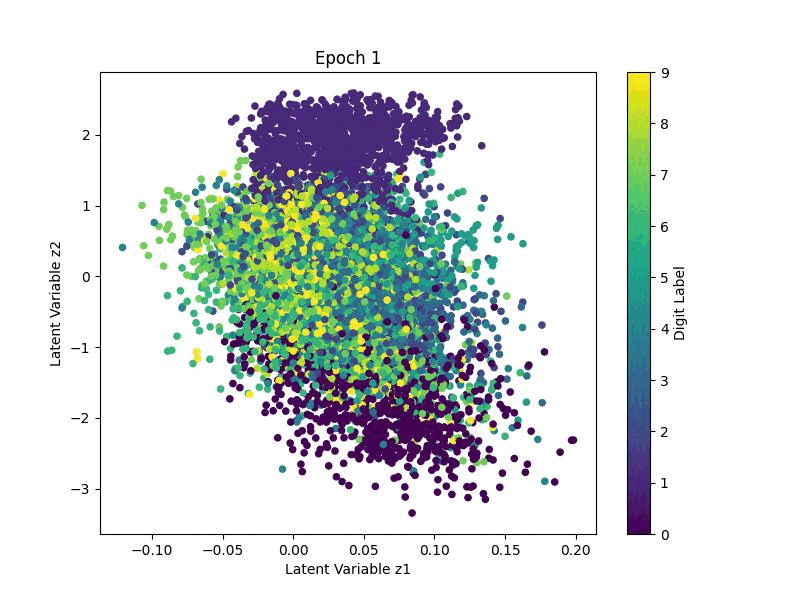

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from IPython.display import Image, display

# Function to get latent space representations for MNIST dataset at different epochs
def get_latent_space_epochs(vae, data_loader, epochs):
    latent_vectors_epochs = []  # List to store latent space representations for each epoch
    
    for epoch in range(epochs):
        latent_vectors = []  # List to store latent space representations for current epoch
        with torch.no_grad():
            vae.eval()  # Set VAE model to evaluation mode
            for batch_idx, (data, label) in enumerate(data_loader):
                data = data.to(device)
                mu, _ = vae.encode(data)  # Encode input data to get latent space representations
                latent_vectors.append(mu.cpu().numpy())  # Append latent vectors to the list
        
        latent_vectors = np.concatenate(latent_vectors)  # Concatenate latent vectors for this epoch
        latent_vectors_epochs.append(latent_vectors)  # Store latent space representations for this epoch
    
    return latent_vectors_epochs  # Return a list of latent space representations for each epoch

# Load MNIST test data and create a data loader
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract labels from the test dataset
labels = []
for _, label in test_loader:
    labels.extend(label.numpy())  # Collect labels for each image in the test dataset

# Set the number of epochs to capture
epochs_to_capture = 20  # Number of epochs to capture latent spaces

# Get latent space representations for test data at different epochs
latent_vectors_epochs = get_latent_space_epochs(vae, test_loader, epochs_to_capture)

# Save each frame as an image for creating the GIF
for epoch in range(epochs_to_capture):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        latent_vectors_epochs[epoch][:, 0],
        latent_vectors_epochs[epoch][:, 1],
        c=labels, cmap='viridis', s=20
    )
    plt.colorbar(label='Digit Label')
    plt.xlabel('Latent Variable z1')
    plt.ylabel('Latent Variable z2')
    plt.title(f'Epoch {epoch + 1}')
    plt.savefig(f'latent_space_epoch_{epoch}.jpg')  # Save the figure as an image
    plt.close()  # Close the figure after saving

# Use ImageMagick convert command to generate GIF from saved images
convert_cmd = '/usr/local/bin/convert -delay 20 -loop 0 latent_space_epoch_*.jpg latent-space.gif'
subprocess.run(convert_cmd, shell=True)  # Execute the convert command to create the GIF
gif_path = 'latent-space.gif'  # Path to the generated GIF file

# Display the generated GIF in the notebook
display(Image(filename=gif_path))


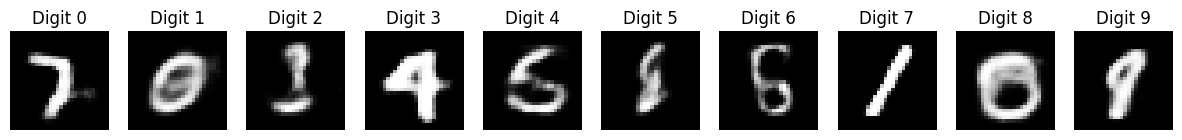

In [14]:
# function to generate images for all digits (0-9)
def generate_images_for_all_digits(vae_model, latent_dim):
    with torch.no_grad():
        vae_model.eval()  # Set the VAE model to evaluation mode
        latent_vectors = torch.randn(10, latent_dim).to(device)  # Generate random latent vectors for each digit
        generated_images = vae_model.decode(latent_vectors).cpu()  # Decode latent vectors to generate images
        
        # Plotting the generated images for each digit using subplots
        fig, axs = plt.subplots(1, 10, figsize=(15, 3))  # Create a figure with 1 row and 10 columns for images
        for i in range(10):
            axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')  # Display each generated image
            axs[i].axis('off')  # Hide axis labels
            axs[i].set_title(f'Digit {i}')  # Set title for each subplot representing a digit
        plt.show()  # Display the figure containing all generated digit images

# Assuming `vae` is the trained VAE model and `latent_dim` is the dimension of the latent space
latent_dim = 20  # Adjust the latent space dimension according to your VAE model
generate_images_for_all_digits(vae, latent_dim)  # Generate and display images for all digits using the provided VAE model


You have two implementation options: (1) All in one notebook (2) Github repo. 

### Option 1: All in one Colab notebook

You submit a single Colab notebook URL that contains all the code and the outputs. Your notebook should be self-contained and can be launched in Google Colab using a corresponding button at the top of the notebook. See the regression notebook in the course site for an example of such button. You **need to save all outputs in the notebook** so that the TAs can check that your code is working properly. 

### Option 2: Github repo 

If you prefer to work without notebooks, with containers or not, you can submit the implementation python scripts and version control your code in a private Github repo. You have to submit the Github URL and clearly document the way to launch the runtime / install requirements.txt and include all required figures in the README.md file. 

IMPORTANT: Ensure that the github repo remains private. If you submit a public github repo you will be held responsible for violating the honor code.